# References

Bojarski, Mariusz& Testa, Davide& Dworakowski, Daniel & Firner, Bernhard & Flepp, Beat & Goyal, Prasoon& Jackel, Larry & Monfort, Mathew & Muller, Urs& Zhang, Jiakai& Zhang, Xin & Zhao, Jake & Zieba, Karol. (2016). End to End Learning for Self-Driving Cars.

# Installing the Environment

1. ```conda create -n self-driving-car```
2. ```conda activate self-driving-car```
3. ```pip install -r requirements.txt```

In [1]:
import os
import csv
import cv2
import matplotlib.pyplot as plt
import random

OS - Interact with the operating system. It allows you to perform operations such as creating, deleting, renaming files and directories

CSV - This module allows you to read and write data in CSV


In [2]:
data_path='data_02'
label_path='data_02/driving_log.csv'

In [ ]:
import pandas as pd
import numpy as np

dataset=pd.read_csv(label_path)
dataset.head()

**INPUT_SHAPE** is a tuple that combines the height, width, and color channels into a single variable

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

**.vlaues** convert the dataframe to array into numpy array

In [5]:
dataset=dataset.values
data=dataset[:,0:3]
target=dataset[:,3]

In [6]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [7]:
def load_image(data_dir):

    img=cv2.imread(data_dir)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    return img

1.  image cropping by removing the top 60 rows and bottom 25 rows from the input image. **:** selects all columns and color channels
2. **cv2.INTER_AREA** flag specifies the interpolation method used for resizing, which is suitable for shrinking images.

In [8]:
def preprocess(img):

    # Cropping the image
    img = img[60:-25, :, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

1. **np.random.choice(3)** randomly selects an integer from 0, 1, or 2 with equal probability.
If the randomly chosen integer is 0, the function returns the center image **(load_image(center))** and the original steering angle (steering_angle) without any modification.
2. If the randomly chosen integer is 1, the function returns the left image **(load_image(left))** and adjusts the steering angle by adding 0.2 **(steering_angle + 0.2)**.
3. If the randomly chosen integer is 2, the function returns the right image **(load_image(right))** and adjusts the steering angle by subtracting 0.2 **(steering_angle - 0.2)**.

In [9]:
def random_adjust(center, left, right, steering_angle):

    choice = np.random.choice(3)
    
    if choice == 0:
        
        return load_image(center), steering_angle
    
    elif choice == 1:
        
        return load_image(left), steering_angle + 0.2
    
    else:
    
        return load_image(right), steering_angle - 0.2

In [10]:
def display(image, angle, label):
    plt.imshow(image)
    plt.xlabel("Steering angle: {:.5f}".format(angle))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.show()

**random_flip** function performs random horizontal flipping of input images and adjusts the corresponding steering angle. Its one of the agumentation technique used.

**np.random.rand() < 0.5** random number between 0 and 1 using NumPy's random number generator. If the random number is less than 0.5, the condition is true, and the image will be flipped horizontally

A positive steering angle typically means turning right, and a negative steering angle means turning left

In [11]:
def random_flip(image, steering_angle):

    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

Randomly translating the images during training

**random_shift** function performs random translational shifting of input images and adjusts the corresponding steering angle. it generates two random values, **trans_x** and **trans_y**, within the specified ranges using np.**random.rand()**. Then adjusts the **steering_angle** based on the **trans_x** offset (adjustment is important because translating the image horizontally affects the perceived steering angle)

**cv2.warpAffine** is used to apply the translational transformation to the input image. The function returns the transformed image and the adjusted steering angle

In [12]:
def random_shift(image, steering_angle, range_x, range_y):

    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

Below function takes an input image and starts by defining a **bright_factor** of 0.3, which will be used to darken a random region of the image, simulating a shadow effect.

Then generates random coordinates (x, y) and dimensions (width, height) for a rectangular region within the input image. heAfter that it converts the input image from the **RGB** colour space to the **HSV** colour space using **cv2.cvtColor**. (it important to shadowing effect will be applied to the Value (V) channel of the HSV image)

In [13]:
def random_shadow(image):

    bright_factor = 0.3
    x = random.randint(0, image.shape[1])
    y = random.randint(0, image.shape[0])
    width = random.randint(image.shape[1], image.shape[1])
    if(x + width > image.shape[1]):
        x = image.shape[1] - x
    height = random.randint(image.shape[0], image.shape[0])
    if(y + height > image.shape[0]):
        y = image.shape[0] - y
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[y:y+height,x:x+width,2] = image[y:y+height,x:x+width,2]*bright_factor
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

**random_brightness** - This function randomly adjusts the brightness of the input image, simulating varying lighting conditions. 

If the ratio is greater than 1.0, the pixels will become brighter, creating a overexposed img. If the ratio is less than 1.0, the pixels will become darker, creating a  underexposed img.

In [14]:
def random_brightness(image):

    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Augmentation Function

 Here the below function that combines multiple data augmentation techniques to create a diverse set of augmented images and corresponding steering angles from the input center, left, and right camera images and the initial steering angle. 

 After applying all these data augmentation techniques, the function returns the augmented image and the corresponding adjusted steering angle.

In [15]:
def augument(center, left, right, steering_angle, range_x=100, range_y=10):

    image, steering_angle = random_adjust(center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_shift(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

# Nvidia CNN

In [16]:
# from keras.models import Sequential
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
# from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
# from keras.regularizers import l2

# def NVIDIA_model():
    
#     model = Sequential()
#     model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
#     model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
#     model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
#     model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='elu'))
#     model.add(Conv2D(64, (3, 3), activation='elu'))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(100, activation='elu'))
#     model.add(Dense(50, activation='elu'))
#     model.add(Dense(10, activation='elu'))
#     model.add(Dense(1))
#     #model.summary()
    
#     model.compile(loss='mse', optimizer=Adam(lr=1.0e-4))
    
#     return model

# model.summary()

In [17]:
from keras.layers import BatchNormalization

In [18]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.regularizers import l2
from keras.initializers import he_normal

def NVIDIA_model():
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2), kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2), kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2), kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu', kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='elu', kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='elu', kernel_regularizer=l2(0.0001),kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer=Adam(lr=1.0e-4))
    
    return model

This is a Generator function that is used to create batches of input data (images and corresponding steering angles) for training or evaluation.

The **batcher** function is designed to be used in a loop or with other data loading mechanisms to continuously generate batches of data for training or evaluation. During training, the function applies various data augmentation techniques to the input images with a **60%** probability, which helps increase the diversity of the training data and improve the model's generalization ability

In [19]:
def batcher(image_paths, steering_angles, batch_size, training_flag):

    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            if training_flag and np.random.rand() < 0.6:
                image, steering_angle = augument(center, left, right, steering_angle)
            else:
                image = load_image(center) 
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [20]:
batch_size = 20
samples_per_epoch = 2000
nb_epoch = 30

In [21]:
model = NVIDIA_model()   

callbacks = [
    ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min', verbose=1)
]

checkpoint = ModelCheckpoint('models/model-EP-{epoch:02d}-L-{val_loss:.2f}.h5',monitor='val_loss',save_best_only=True,mode='auto')
    
history = model.fit_generator(batcher(train_data, train_target, batch_size, True),samples_per_epoch,nb_epoch,
                        validation_data=batcher(test_data, test_target, batch_size, False),validation_steps=len(test_data)//batch_size,callbacks=[checkpoint])

c:\Users\udula\anaconda3\envs\self-driving-car\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2000/2000 [==============================] - 224s 111ms/step - loss: 0.4850 - val_loss: 0.1609
Epoch 2/30
2000/2000 [==============================] - 260s 130ms/step - loss: 0.1859 - val_loss: 0.1442
Epoch 3/30
2000/2000 [==============================] - 273s 137ms/step - loss: 0.1756 - val_loss: 0.1447
Epoch 4/30
2000/2000 [==============================] - 280s 140ms/step - loss: 0.1653 - val_loss: 0.1394
Epoch 5/30
2000/2000 [==============================] - 280s 140ms/step - loss: 0.1570 - val_loss: 0.1274
Epoch 6/30
2000/2000 [==============================] - 289s 145ms/step - loss: 0.1469 - val_loss: 0.1284
Epoch 7/30
2000/2000 [==============================] - 277s 139ms/step - loss: 0.1398 - val_loss: 0.1156
Epoch 8/30
2000/2000 [==============================] - 272s 136ms/step - loss: 0.1327 - val_loss: 0.1099
Epoch 9/30
2000/2000 [==============================] - 259s 130ms/step - loss: 0.1251 - val_loss: 0.1039
Epoch 10/30
2000/2000 [=======================

In [22]:
import matplotlib.pyplot as plt

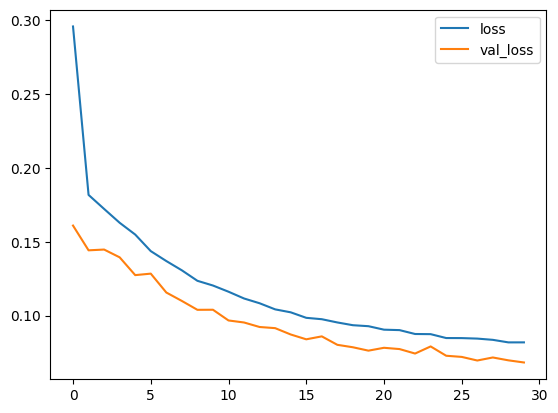

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()


In [24]:

trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
print(f'Total Trainable Parameters: {trainable_params}')

# Get the total size of the model in megabytes
def get_model_size(model):
    params = model.count_params()  # Total number of parameters
    size_in_bytes = params * 4  
    size_in_mb = size_in_bytes / (1024 ** 2)  
    return size_in_mb

model_size_mb = get_model_size(model)
print(f'Model size: {model_size_mb:.2f} MB')

Total Trainable Parameters: 253011
Model size: 0.97 MB
